In [6]:
import os
import pandas as pd
from fastai.vision.all import *
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import numpy as np

In [7]:
data_dir = '/kaggle/input/large-captcha-dataset/Large_Captcha_Dataset'

data = []
for filename in os.listdir(data_dir):
    if filename.endswith('.png'):
        label = filename[:-4]
        data.append((os.path.join(data_dir, filename), label))

df = pd.DataFrame(data, columns=['image_path', 'label'])

def check_image(file_path):
    try:
        img = Image.open(file_path)
        img.verify()
        return True
    except:
        return False

df = df[df['image_path'].apply(check_image)]
print(f"Total valid images: {len(df)}")

Total valid images: 82328


/opt/conda/lib/python3.10/site-packages/fastai/data/transforms.py:214: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  o = r[c] if isinstance(c, int) or not c in getattr(r, '_fields', []) else getattr(r, c)


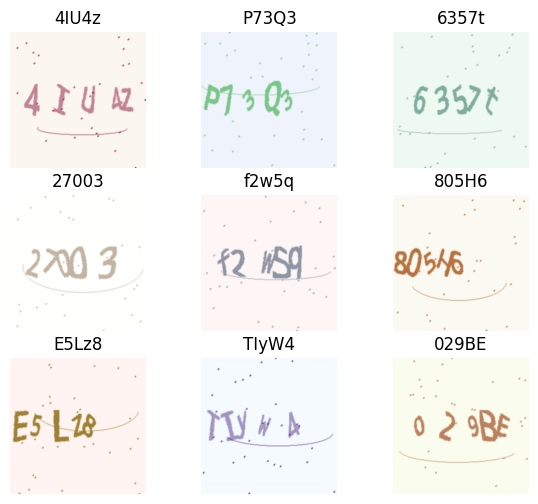

In [26]:
from fastai.vision.all import *

# Assuming 'df' is your DataFrame containing the image paths and labels
# Ensure 'folder' is the directory where your images are stored, and the path is correctly set.
path = Path('../../')  # Replace with your actual directory path

# Use from_df to create the DataLoader from the DataFrame
data = ImageDataLoaders.from_df(df, path, valid_pct=0.2, label_col=1, item_tfms=Resize((256, 256)))

# Show a batch of images
data.show_batch(nrows=3, figsize=(7, 6))

In [27]:
learn = cnn_learner(data, models.resnet50, metrics=accuracy)
lr=1e-2
learn.fit_one_cycle(14,slice(lr),wd=0.01)

/opt/conda/lib/python3.10/site-packages/fastai/vision/learner.py:303: UserWarning: `cnn_learner` has been renamed to `vision_learner` -- please update your code
  warn("`cnn_learner` has been renamed to `vision_learner` -- please update your code")


epoch,train_loss,valid_loss,accuracy,time


KeyError: Caught KeyError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/fastai/data/transforms.py", line 263, in encodes
    return TensorCategory(self.vocab.o2i[o])
KeyError: 'K4m87'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/worker.py", line 309, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
  File "/opt/conda/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 42, in fetch
    data = next(self.dataset_iter)
  File "/opt/conda/lib/python3.10/site-packages/fastai/data/load.py", line 140, in create_batches
    yield from map(self.do_batch, self.chunkify(res))
  File "/opt/conda/lib/python3.10/site-packages/fastcore/basics.py", line 245, in chunked
    res = list(itertools.islice(it, chunk_sz))
  File "/opt/conda/lib/python3.10/site-packages/fastai/data/load.py", line 170, in do_item
    try: return self.after_item(self.create_item(s))
  File "/opt/conda/lib/python3.10/site-packages/fastai/data/load.py", line 177, in create_item
    if self.indexed: return self.dataset[s or 0]
  File "/opt/conda/lib/python3.10/site-packages/fastai/data/core.py", line 449, in __getitem__
    res = tuple([tl[it] for tl in self.tls])
  File "/opt/conda/lib/python3.10/site-packages/fastai/data/core.py", line 449, in <listcomp>
    res = tuple([tl[it] for tl in self.tls])
  File "/opt/conda/lib/python3.10/site-packages/fastai/data/core.py", line 408, in __getitem__
    return self._after_item(res) if is_indexer(idx) else res.map(self._after_item)
  File "/opt/conda/lib/python3.10/site-packages/fastai/data/core.py", line 368, in _after_item
    def _after_item(self, o): return self.tfms(o)
  File "/opt/conda/lib/python3.10/site-packages/fastcore/transform.py", line 210, in __call__
    def __call__(self, o): return compose_tfms(o, tfms=self.fs, split_idx=self.split_idx)
  File "/opt/conda/lib/python3.10/site-packages/fastcore/transform.py", line 160, in compose_tfms
    x = f(x, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/fastcore/transform.py", line 83, in __call__
    def __call__(self, x, **kwargs): return self._call('encodes', x, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/fastcore/transform.py", line 93, in _call
    return self._do_call(getattr(self, fn), x, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/fastcore/transform.py", line 99, in _do_call
    return retain_type(f(x, **kwargs), x, ret)
  File "/opt/conda/lib/python3.10/site-packages/fastcore/dispatch.py", line 122, in __call__
    return f(*args, **kwargs)
  File "/opt/conda/lib/python3.10/site-packages/fastai/data/transforms.py", line 265, in encodes
    raise KeyError(f"Label '{o}' was not included in the training dataset") from e
KeyError: "Label 'K4m87' was not included in the training dataset"


In [16]:
lr = 1e-2
learn.fit_one_cycle(14, slice(lr), wd=0.01)

learn.save('first_character_model')

epoch,train_loss,valid_loss,accuracy,time


KeyboardInterrupt: 

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12, 12), heatmap=True)

In [ ]:
learn_list = []
for i in range(5):
    data = ImageDataBunch.from_df('', train_df, folder='', size=(77, 247), label_col=i)
    learn = cnn_learner(data, models.resnet50, metrics=accuracy)
    lr = 1e-2
    learn.fit_one_cycle(30, max_lr=lr, wd=0.01)
    
    learn.save(f'char_{i+1}_model')
    learn_list.append(learn)

In [ ]:
def predict_captcha(image_path):
    predictions = []
    for learn in learn_list:
        img = open_image(image_path)
        pred_class, pred_idx, outputs = learn.predict(img)
        predictions.append(str(pred_class))
    return ''.join(predictions)

test_image_path = '/path/to/test/captcha.png'  # Replace with a test image path
predicted_text = predict_captcha(test_image_path)
print(f"Predicted CAPTCHA text: {predicted_text}")

In [ ]:
def show_examples(df, num_examples=5):
    fig, axes = plt.subplots(1, num_examples, figsize=(15, 5))
    for ax in axes:
        idx = np.random.randint(len(df))
        row = df.iloc[idx]
        ax.imshow(open_image(row['image_path']))
        ax.title.set_text(f"True: {row['label']}\nPred: {predict_captcha(row['image_path'])}")
        ax.axis('off')

show_examples(valid_df)